# Simulating K2-141b observations with NIRISS/SOSS
--------------------------------------------------------------
**Author**: Néstor Espinoza (nespinoza@stsci.edu) | **Latest update**: July 20, 2020.

## Table of contents
1. [Introduction](#intro)
2. [Preparing planetary and stellar models](#preamble)
   1. [Obtaining a transit spectrum from ExoCTK](#tmodel)
   2. [Obtaining limb-darkening coefficients from ExoCTK](#lds)
3. [Simulating JWST observations of a transit of HAT-P-1b with NIRISS/SOSS](#simulation)
4. [Understanding the simulated data structure](#structure)

1.<font color='white'>-</font>Introduction <a class="anchor" id="intro"></a>
------------------
   Simulating JWST observations is an important part of the process of preparing ourselves for the type of precisions and challenges the observatory will be providing us with. This notebook is part of a series of notebooks that are being prepared by STScI in order to showcase how to simulate, process and analyze JWST observations for a wide range of science cases. Here, we touch on the transiting exoplanet observations science case and, in particular, on spectrophotometric observations of the *primary transit of an exoplanet*. During primary transit, the observed flux decrease due to the planet blocking light from the stellar host is proportional to $\delta = (R_p/R_*)^2$ --- a quantity known as the *transit depth*, where $R_p$ is the planetary radius and $R_*$ is the stellar radius. Interestingly, the transit depth is wavelength dependent; i.e., $\delta \equiv \delta (\lambda)$. This is because opacity sources on the planetary atmosphere absorb different amounts of light at different wavelengths and, therefore, the observed planetary radius $R_p$ --- and thus occulted area during transit, $\delta$ --- is wavelength-dependent (see, e.g., [Kreidberg 2018](https://ui.adsabs.harvard.edu/abs/2018haex.bookE.100K/abstract) for a review). This technique, referred to as *transmission spectroscopy* in what follows, aims at obtaining those transit depths as a function of wavelength in JWST observations through the study of ultra-precise transit lightcurves at different wavelengths. 
   
   In this notebook, we will simulate observations that aim to target a primary transit of K2-141b in order to extract its *transmission spectrum*. In essence, to perform NIRISS/SOSS simulations we need to simulate a time-series observation (TSO) [**exposure**, which is in turn composed of several integrations](https://jwst-docs.stsci.edu/understanding-exposure-times). To simulate a TSO exposure with this instrument, we will use the [Advanced Webb Exposure SIMulator for SOSS (`awesimsoss`)](https://github.com/spacetelescope/awesimsoss), which has built-in functions to simulate NIRISS/SOSS integrations incorporating exoplanetary transits. In what follows, it will be assumed you have properly installed the latest version of `awesimsoss` **[Developer note: the results of this notebook in particular were obtained using [version 0.3.3](https://github.com/spacetelescope/awesimsoss/)]**. In addition to this, you will need to have at hand a transmission spectrum model over the NIRISS/SOSS wavelength range ($0.6\mu$m - $3\mu$m). Here we'll assume the spectrum is flat.
   
Before we begin, we import all the needed libraries to this repository:

In [1]:
# Import numpy and matplotlib:
import numpy as np
import matplotlib.pyplot as plt
import os

# Import astropy units:
import astropy.units as q

# Import awesimsoss (the NIRISS/SOSS simulator), and batman, the transit lightcurve generator:
from awesimsoss import ModelTSO
import batman

Now, let's get to work!

2.<font color='white'>-</font>Preparing planetary and stellar models for the simulations <a class="anchor" id="preamble"></a>
--------------------------------------------------------------------
### A.<font color='white'>-</font>Obtaining a transit spectrum from ExoCTK<a class="anchor" id="tmodel"></a>
For this planet, we'll assume a flat transit spectrum:

In [2]:
rprs = 0.02037
wavelength, transit_depth = np.linspace(0.4,3.5,1000), (rprs**2)*np.ones(1000)

3.<font color='white'>-</font>Simulating JWST observations of a transit of K2-141b with NIRISS/SOSS<a class="anchor" id="simulations"></a>
---------------------------------------------------------------------------------------

Equipped with the transit spectrum, we are now ready to use `awesimsoss` to simulate integrations of K2-141b. Before generating them, we set the parameters of both the star and the planet (obtained from [exo.MAST](https://exo.mast.stsci.edu/exomast_planet.html?planet=k2-141b)), which will be ingested into the `awesimsoss` library to generate our simulated frames:

In [3]:
# First, define effective temperature, log(g), [Fe/H] and 
# 2MASS J-magnitude of the host star (the latter obtained from Simbad):
teff, logg, feh, jmag = 4599, 4.62, -0.06, 9.086

# Now define orbital properties of K2-141b, the exoplanet. First, orbital period and time-of-transit center:
P, mid_transit_time = 0.2803244, 57743.5716 + 2400000.5
# Scaled semi-major axis and planet radius (in units of stellar radius), inclination, eccentricity and 
# argument of periastron passage:
a, rp, inc, ecc, omega = 2.264, rprs, 86.3, 0., 90.

Finally, we also set the properties of the NIRISS/SOSS exposure, namely, the duration of the entire exposure, the number integrations  and the number of groups, along with the time at which we wish the observations to start. To define those we ran a [PandExo](https://exoctk.stsci.edu/pandexo/) run on which we asked the program to optimize the groups and integrations --- it seems that at 3 groups per integration one _could_ achieve values close to saturation (but not quite). Also, the transit duration is so short, that if the objective is to target as much in-transit points as out-of-transit points, 308 integrations suffice for the objective. 

As for when to start the observations, we make the observations as realistic as possible here. There are several opportunities between November 2022 and mid-December 2022 with virtually no contamination from nearby objects using [ExoCTK's Contamination Visibility](https://exoctk.stsci.edu/contam_visibility) tool. We pick a random observable JWST event on that window: one of the transits ocurring on December 7, 2022 (`2459920.5102415998` in JD, i.e., epoch 7764 from our transit ephemerides above). Because we want to start 1 hour before this mid-transit time (to account for possible detector settling and to have enough baseline to correct possible systematics), we set the start time to one hour before this mid-transit time --- `2022-12-6T23:14:44.87`:

In [4]:
nintegrations, ngroups, start_time = 308, 3, '2022-12-6T23:14:44.87'

We are now ready to use `awesimsoss`. We first create a `ModelTSO` object, which will initialize the properties of the simulated frame by assuming an input stellar spectrum using an ATLAS9 or PHOENIX model atmosphere as close as possible to our input stellar properties. By default, `awesimsoss` generates simulations using SUBSTRIP256, which contains both the optical and infrared order of NIRISS/SOSS. We choose to model our star using an ATLAS9 model. On top of that, we define the currently allowed number of resets for NIRISS/SOSS observations (`nresets = 1`), and define the name of the target which will simply add the correct RA and DEC to the headers:

In [5]:
tsoframes = ModelTSO(ngrps=ngroups, nints=nintegrations, nresets = 1, teff = teff, logg = logg, 
                     feh = feh, jmag = jmag, stellar_model = 'ATLAS', obs_date = start_time, 
                     target = 'K2-141', run = False)

Coordinates 350.91654583333326 -1.1892916666666666 for 'K2-141' found in Simbad!


Now we create the transit model that we will be injecting to the data. For this, we create a supersampled lightcurve of K2-141b in order to account for the finite integration time of each of the frames (which is approximately 5.5 seconds):

In [6]:
params = batman.TransitParams()
params.t0 = mid_transit_time # time of inferior conjunction
params.per = P # orbital period (days)
params.a = a # semi-major axis (in units of stellar radii)
params.rp = rp # radius ratio for Jupiter orbiting the Sun
params.inc = inc # orbital inclination (in degrees)
params.ecc = ecc # eccentricity
params.w = omega # longitude of periastron (in degrees) p
params.limb_dark = 'quadratic' # limb darkening profile to use
params.u = [0.1,0.1] # limb darkening coefficients; just initializations for now
supersample_factor = 10

tmodel = batman.TransitModel(params, tsoframes.time.jd, 
                             supersample_factor = supersample_factor, 
                             exp_time = tsoframes.frame_time*(1./(3600.*24.)))

# Stellar parameters --- will be useful to generate limb-darkening coefficients internally in 
# awesimsoss:
tmodel.teff = teff
tmodel.logg = logg
tmodel.feh = feh
# Define ATLAS9 as the model grid:
tsoframes.model_grid = 'ATLAS9'

And now we simulate the data, for which we give as inputs our `tmodel` object, as well as the transmission spectrum obtained above. Note this will take a while:

In [7]:
# Define transit spectrum in a awesimsoss-friendly format:
transit_spectrum = [wavelength*q.um, transit_depth]

# Run if not ran already. Save to file:
outfile = 'data_k2-141_uncal.fits'
if not os.path.exists(outfile):
    tsoframes.simulate(planet=transit_spectrum, tmodel=tmodel, 
                       params = params, supersample_factor = supersample_factor)
    tsoframes.export(outfile)


4.<font color='white'>-</font>Understanding the simulated data structure<a class="anchor" id="structure"></a>
---------------------------------------------------------------------------------------

Before moving forward to the next notebook, in which we'll reduce the data using the JWST pipeline, let's briefly explore the simulated and saved frames in order to understand the structure of the data. First, let's load the fits file to explore the data and headers:

In [8]:
from astropy.io import fits
hdul = fits.open(outfile)
# Print headers:
print(hdul[0].header.keys)
# Print data shape:
data = hdul[1].data
print('\nData shape :',data.shape)

<bound method Header.keys of SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
DATE    = '2020-07-24T01:44:28.221' / UTC date file created                     
FILENAME= 'data_k2-141_uncal.fits' / Name of the file                           
DATAMODL= 'RampModel'          / Type of data model                             
TELESCOP= 'JWST    '           / Telescope used to acquire the data             
                                                                                
        Observation identifiers                                                 
                                                                                
DATE-OBS= '2022-12-06'         / [yyyy-mm-dd] UTC date at start of exposure     

As can be seen from the above, the header of this uncalibrated file contains all the information about the exposure, from the start date of the exposure to the number of integrations, groups per integration, total duration of the exposure and instrument details (subarray, instrument, detector, etc.). As for the data shape, note this is an array of length $(N_{\textrm{integrations}},N_{\textrm{groups}},S,M)$, where $N_{\textrm{integrations}}$ is the number of integrations, $N_{\textrm{groups}}$ is the number of groups per integration, $S$ is the number of pixels in the subarray ("spatial") direction (256 in our case as we are using `SUBSTRIP256`) and $M$ is the number of pixles close to the "wavelength" direction (2048 in our case). At each of those coordinates, there will be a flux value in Digital Units (DUs).

Let's plot an image of the counts for the 5th integration on the 3rd group:

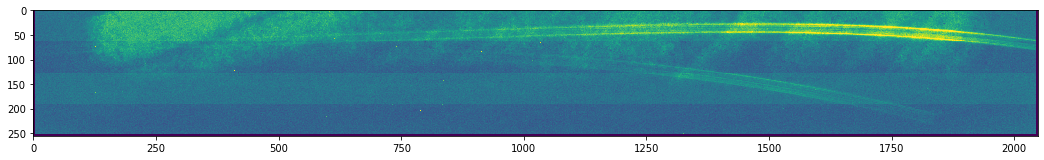

In [9]:
plt.figure(figsize=(18,18))
integration = data[5,2,:,:]
im = plt.imshow(integration)
im.set_clim(0,30000)
plt.show()

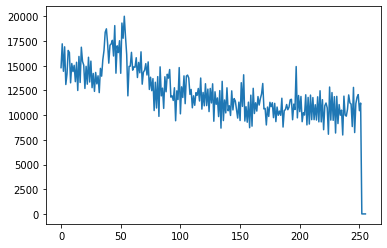

In [10]:
plt.plot(integration[:,1000])

This frame shows the traces of the two orders --- the one on the top is the "order 1" trace, which covers from 1 to 3 microns, whereas the one in the bottom covers the optical range (from 0.6 to around 1 micron). Note the traces partially overlap in the leftside of the image --- a problem we will have to deal with in the future.

We now have our simulated data!